In [1]:
import pandas as pd
import mysql.connector
import os
import ipywidgets as widgets
import numpy as np
import itables.options as opt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from IPython.display import display
from ipywidgets import interactive
from itables import init_notebook_mode
from itables import show
from matplotlib import rcParams
%matplotlib inline

In [2]:
connection = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    passwd = 'bruce2140',
    db ='project')

In [3]:
connection

In [4]:
data = pd.read_sql_query('select * from imdb',connection)

In [5]:
dummies = data['Genre'].str.get_dummies(sep=', ')
print(len(dummies.columns))

21


In [6]:
new = {'movie_genre':['Action', 'Adventure', 'Animation', 'Biography','Comedy','Crime','Drama','Family','Fantasy','Horror','Music','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western']}
df = pd.DataFrame(new)

In [7]:
init_notebook_mode(all_interactive=True)
opt.lengthMenu = [5,10,20,50,100,200,500]
opt.classes = ["display", "cell-border"]
opt.maxBytes = 10000000
opt.columnDefs = [{"className":"dt-left", "targets": "_all","width": "80px"}]

<IPython.core.display.Javascript object>

In [8]:
ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

In [9]:
output = widgets.Output()

dropdown_year = widgets.Dropdown(options = unique_sorted_values_plus_ALL(data.Released_Year))
dropdown_genre = widgets.Dropdown(options = unique_sorted_values_plus_ALL(df.movie_genre))
    
    
def common_filtering(year, genre):
    output.clear_output()
    if (year == ALL) & (genre == ALL):
        common_filter = data
    elif (year == ALL):
        common_filter = data[data.Genre.str.contains(genre)]
    elif (genre == ALL):
        common_filter = data[data.Released_Year == year]
    else:
        common_filter = data[(data.Released_Year == year) & data.Genre.str.contains(genre)]
    with output:
        display(common_filter)



def dropdown_year_eventhandler(change):
    common_filtering(change.new, dropdown_genre.value)
    
def dropdown_genre_eventhandler(change):
    common_filtering(dropdown_year.value,change.new)
    
    
dropdown_year.observe(dropdown_year_eventhandler, names='value')
dropdown_genre.observe(dropdown_genre_eventhandler, names='value')

In [10]:
item_layout = widgets.Layout(margin='0 0 50px 0')
input_widgets = widgets.HBox([dropdown_year, dropdown_genre],layout =item_layout)
tab = widgets.Tab([output],layout =item_layout)
tab.set_title(0, 'Dataset Exploration')

In [11]:
#Search function and data exploration
dashboard = widgets.VBox([input_widgets, tab])
display(dashboard)

## Runtime

In [12]:
#runtime count
runtime = data['Runtime'].value_counts()
runtime

,Runtime


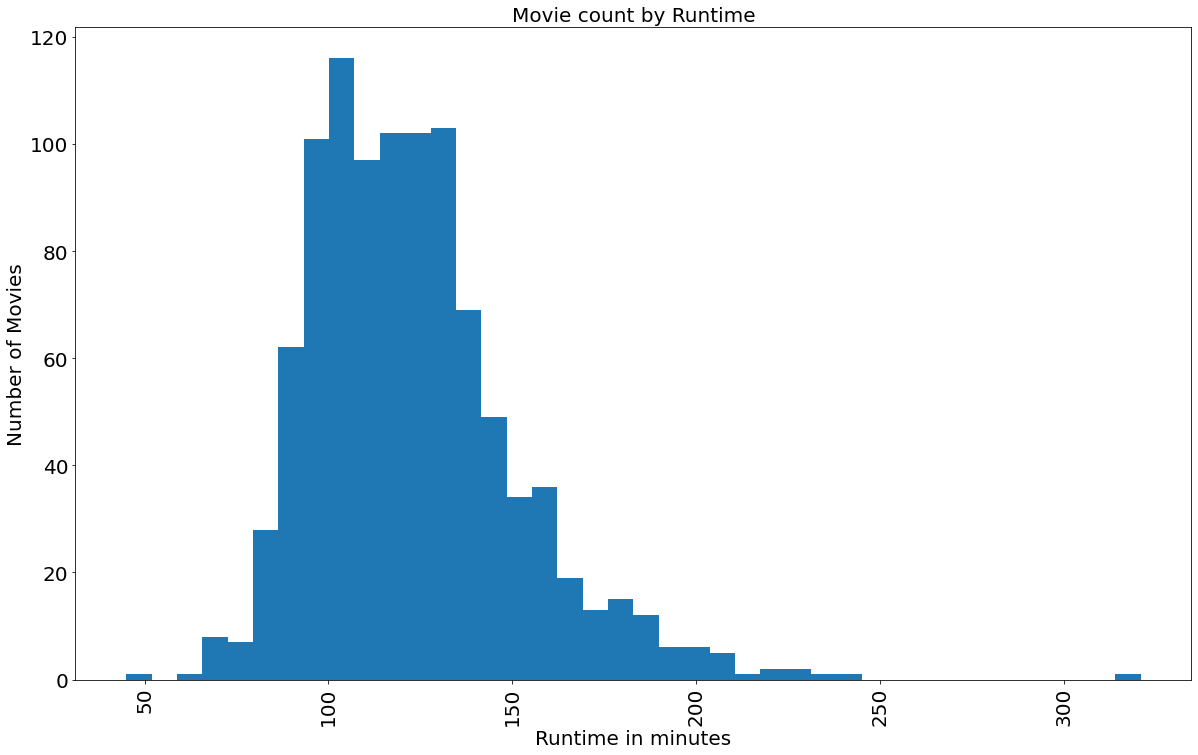

In [13]:
#runtime count visualization
data['Runtime'].plot.hist(bins=40,figsize=(20,12))
plt.title("Movie count by Runtime",fontsize=20)
plt.xlabel('Runtime in minutes',fontsize=20)
plt.ylabel('Number of Movies',fontsize=20)
plt.xticks(fontsize=20,rotation=90)
plt.yticks(fontsize=20)
plt.show()

In [14]:
#expand column function to split multiple values inside a pandas column into separate columns
def expand_col(df_src, col, sep=', '):
    di = {}
    idx = 0
    for i in df_src.iterrows():
        d = i[1]
        names = d[col].split(sep)
        for name in names:
            # operate on a copy to not overwrite previous director names
            c = d.copy()
            c[col] = name
            di[idx] = c
            idx += 1

    df_new = pd.DataFrame(di).transpose()

    return df_new

In [15]:
df_genre = expand_col(data,'Genre')

In [16]:
df_genre['IMDB_Rating'] = pd.to_numeric(df_genre['IMDB_Rating'])

## Genre

In [17]:
#number of occurences by each genre
genre_count = df_genre['Genre'].value_counts()
genre_count

,Genre


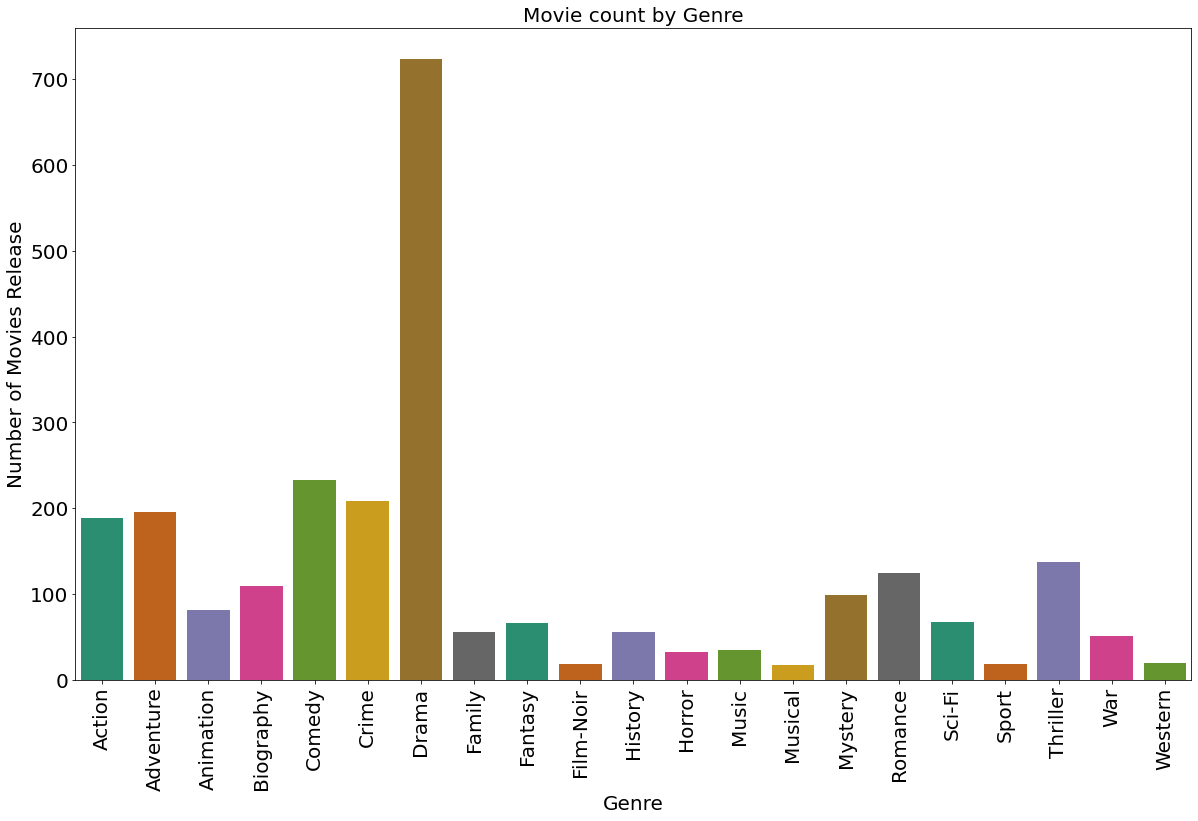

In [18]:
#visualization of movie count by genre
plt.figure(figsize=(20,12)),sns.countplot(df_genre['Genre'].sort_values(),palette = 'Dark2')
plt.title("Movie count by Genre",fontsize=20)
plt.xlabel('Genre',fontsize=20)
plt.ylabel('Number of Movies Release',fontsize=20)
plt.xticks(fontsize=20,rotation=90)
plt.yticks(fontsize=20)
plt.show()

In [19]:
df_genre.sort_values('IMDB_Rating', ascending=False).groupby('Genre')[['Series_Title','IMDB_Rating']].first()

,Series_Title,IMDB_Rating
Genre,,


## Directors

In [20]:
#counts of the directors
director = data['Director'].value_counts()
director

,Director


In [21]:
#Average IMDB_Rating by directors
top_directors = director.index
data[data.Director.isin(top_directors)].groupby('Director').IMDB_Rating.mean()\
    .reset_index(name="Average Rating")

Director,Average Rating


In [22]:
#Total Box office profit by directors
data[data.Director.isin(top_directors)].groupby('Director').Gross.sum()\
    .reset_index(name="Total Box Office")

Director,Total Box Office


In [23]:
#Average Box office profit by directors
data[data.Director.isin(top_directors)].groupby('Director').Gross.mean()\
    .reset_index(name="Average Box Office")

Director,Average Box Office


## Released Year

In [24]:
year = data['Released_Year'].value_counts()
year

,Released_Year


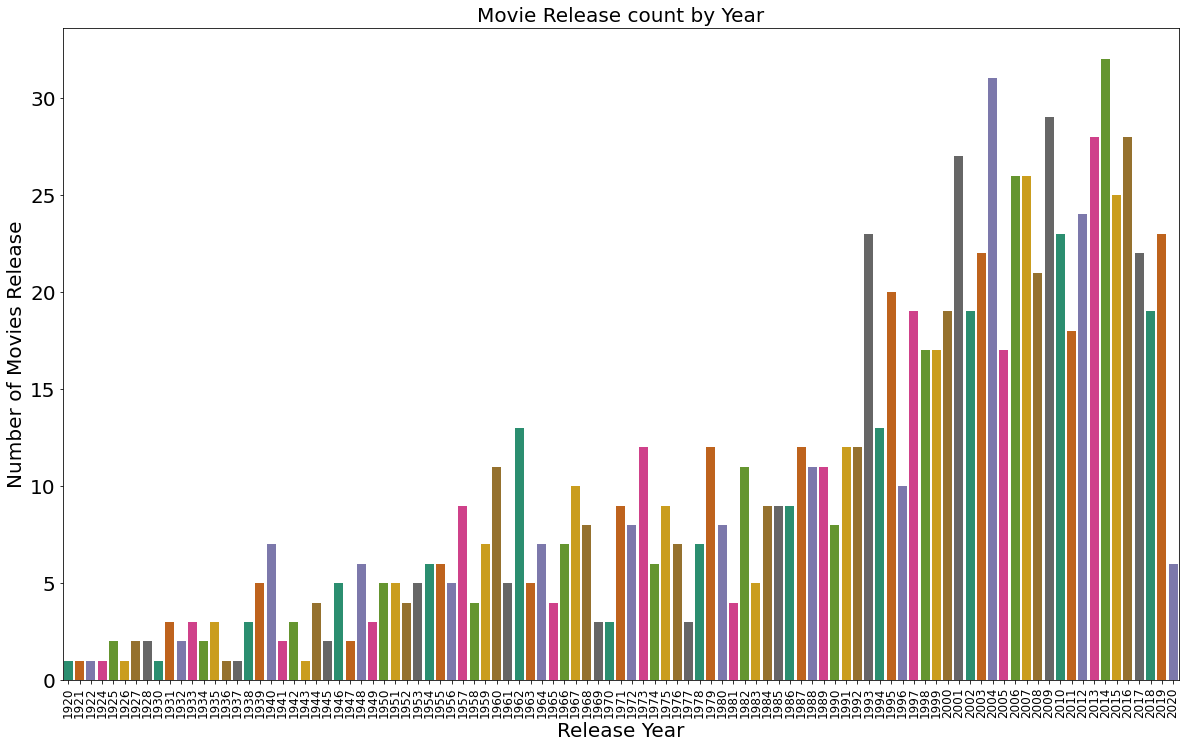

In [25]:
plt.figure(figsize=(20,12)),sns.countplot(data['Released_Year'].sort_values(),palette = 'Dark2')
plt.title("Movie Release count by Year",fontsize=20)
plt.xlabel('Release Year',fontsize=20)
plt.ylabel('Number of Movies Release',fontsize=20)
plt.xticks(fontsize=12,rotation=90)
plt.yticks(fontsize=20)
plt.show()

In [26]:
top_year = year.index
data[data.Released_Year.isin(top_year)].groupby('Released_Year').Gross.mean()\
    .reset_index(name="Average Gross")

Released_Year,Average Gross


In [27]:
data[data.Released_Year.isin(top_year)].groupby('Released_Year').Gross.sum()\
    .reset_index(name="Overall Gross")

Released_Year,Overall Gross
